## <b> Modeling </b> notebook (Nr 3) for <b>Project 2</b> of General Assembly DSIR-0320 
by Martijn de Vries </br>
martijndevries91@gmail.com

## Problem Statement

A real estate company in Ames, Iowa is looking for a new and improved way to evaluate the market value of a house. Using the Ames data set as training data, we will build a predictive linear regression model to predict the sale price of a house as well as possible.

To gauge the model performance, I will compare my results against a 'benchmark model', which is a simple OLS regression of total living area versus sale price. How much can a more complex model improve over this simple basic model? I will try out different models with different numbers of features using different linear regression techniques, and ultimately identify which model does the best job at predicting the market value of the house.

## In this notebook

I will load in the various models with increasing complexity, run a variety of regressions; using the SalePrice, log-transform of the SalePrice, and also using OLS, Ridge and Lasso regressors. I split the training data into a training and validation set, and evaluate the models by calculating the r2 scores, RMSE, and cross val scores.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

#sklearn imports
from sklearn.linear_model import LinearRegression,LassoCV,Ridge,RidgeCV
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline


## Benchmark Model

The benchmark model is a simple linear regression of total living area vs saleprice. 

In [2]:
df_model= pd.read_csv('../model_inputs/train_engineered_m1.csv')
df_model.head()

,Id,tot_area,gar_adj_area,yr_built,yr_remod,qual,Overall Cond,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RM,Func_Maj,Func_Min,Func_Mod,Func_Sev,SalePrice
0,109,2204.0,475.000000,1976,2005,6,8,0,0,0,0,0,0,0,0,0,130500
1,544,3035.0,559.000000,1996,1997,7,5,0,0,0,0,0,0,0,0,0,220000
2,153,2114.0,164.452998,1953,2007,5,7,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,457.146484,2006,2007,5,5,0,0,0,0,0,0,0,0,0,174000
4,255,2121.0,323.557931,1900,1993,6,8,0,0,0,0,0,0,0,0,0,138500


In [3]:
X = df_model[['tot_area']]
y = df_model['SalePrice']

X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

Before I start fitting, let's define a print_metrics function that calculates R2, RMSE and cross val scores

In [4]:
def print_metrics(r_obj, X_train, X_val, y_train, y_val, islog=False):
    """
    for a given regression object, and input training/validation data, print out 1) the r2 score, 2) the cross-validation score of the training data, and 
    3) the RMSE for both the training and validation data
    assumes y-values are not log transformed. if islog=True, the log transformation happens within this function
    """
    
    if islog == False:
        train_score = r_obj.score(X_train, y_train)
        val_score = r_obj.score(X_val, y_val)
    elif islog == True:
        train_score = r_obj.score(X_train, np.log(y_train))
        val_score = r_obj.score(X_val, np.log(y_val))
    print(f'The training r2 score is {str(train_score)}')
    print(f'The validation r2 score is {str(val_score)}')

    if islog == False:
        crossval = np.average(cross_val_score(r_obj, X_train, y_train))
    elif islog == True:
        crossval = np.average(cross_val_score(r_obj, X_train, np.log(y_train)))
    
    print(f'The cross validation score is {str(crossval)}')
    print('-'*60)
                
    preds_train = r_obj.predict(X_train)
    preds_val = r_obj.predict(X_val)
    
    #RMSE in dollars
    if islog == False:
        rmse_val =  mean_squared_error(y_val, preds_val, squared=False)
        rmse_train =  mean_squared_error(y_train, preds_train, squared=False)
    elif islog == True:
        rmse_val =  mean_squared_error(y_val, np.exp(preds_val), squared=False)
        rmse_train =  mean_squared_error(y_train, np.exp(preds_train), squared=False)
        
    print(f'The training RMSE score is {str(rmse_train)}')
    print(f'The validation RMSE score is {str(rmse_val)}')
    
    return

For each model, I should split the training data I have into a training and testing data so I can evaluate how well the model does. The problem is that I already have a 'testing' set, which is the data with no saleprice included (ie I can't use it to evaluate the model). So in this notebook, I'll call the withheld data I use to evaluate the model the 'validation' data, or X_val, y_val, etc.

In [5]:
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

In [6]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [7]:
print('The metrics for the benchmark model (Simple least squares, with total living area as the predictor variable)')
print('-'*60)
print_metrics(lr, X_train, X_val, y_train, y_val)

The metrics for the benchmark model (Simple least squares, with total living area as the predictor variable)
------------------------------------------------------------
The training r2 score is 0.6943023042761038
The validation r2 score is 0.6387963066523947
The cross validation score is 0.6918200458030501
------------------------------------------------------------
The training RMSE score is 43672.87991366827
The validation RMSE score is 47900.07573530223


## Model 1

In [8]:
#load in the feature engineered training data for model 1
df_model= pd.read_csv('../model_inputs/train_engineered_m1.csv')
df_model.head()

,Id,tot_area,gar_adj_area,yr_built,yr_remod,qual,Overall Cond,MS Zoning_C (all),MS Zoning_FV,MS Zoning_I (all),MS Zoning_RH,MS Zoning_RM,Func_Maj,Func_Min,Func_Mod,Func_Sev,SalePrice
0,109,2204.0,475.000000,1976,2005,6,8,0,0,0,0,0,0,0,0,0,130500
1,544,3035.0,559.000000,1996,1997,7,5,0,0,0,0,0,0,0,0,0,220000
2,153,2114.0,164.452998,1953,2007,5,7,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,457.146484,2006,2007,5,5,0,0,0,0,0,0,0,0,0,174000
4,255,2121.0,323.557931,1900,1993,6,8,0,0,0,0,0,0,0,0,0,138500


In [9]:
X = df_model.drop(columns=['Id', 'SalePrice'])
y = df_model['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)

In [10]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [11]:
print_metrics(lr, X_train, X_val, y_train, y_val)

The training r2 score is 0.8364646924759667
The validation r2 score is 0.8322937626582069
The cross validation score is 0.8307021724801407
------------------------------------------------------------
The training RMSE score is 31942.692071990143
The validation RMSE score is 32638.840088824727


The model is not overfit, given the good agreement in scores. Let's make a residual plot as well:

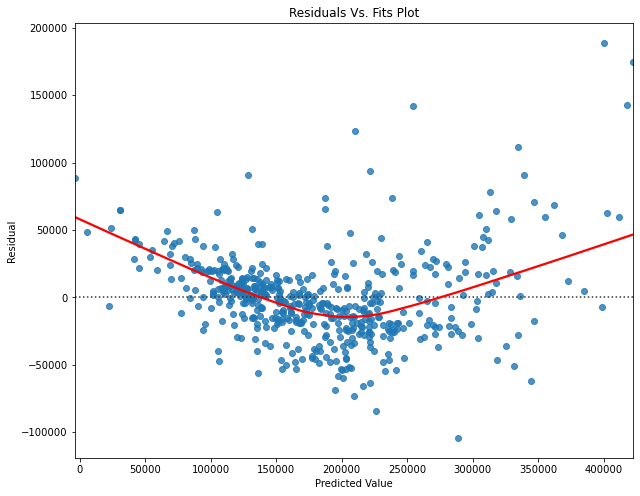

In [12]:
preds_val = lr.predict(X_val)
resids = y_val - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,  y = resids, lowess = True, 
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

It seems that the linearity and equal variance of errors assumptions are definitely violated. The model is underfit, we could probably do quite a bit better.

In the feature engineering notebook, we saw that it seems that at least for some predictor variables, the relationship seems more linear to log(SalePrice) rather than SalePrice. What if I fit using that instead?

In [13]:
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [14]:
print_metrics(lr, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.8918071308186171
The validation r2 score is 0.8619414346911233
The cross validation score is 0.8878700070800246
------------------------------------------------------------
The training RMSE score is 25970.4825715732
The validation RMSE score is 25859.827882086647


This seems to improve thigs a little bit!

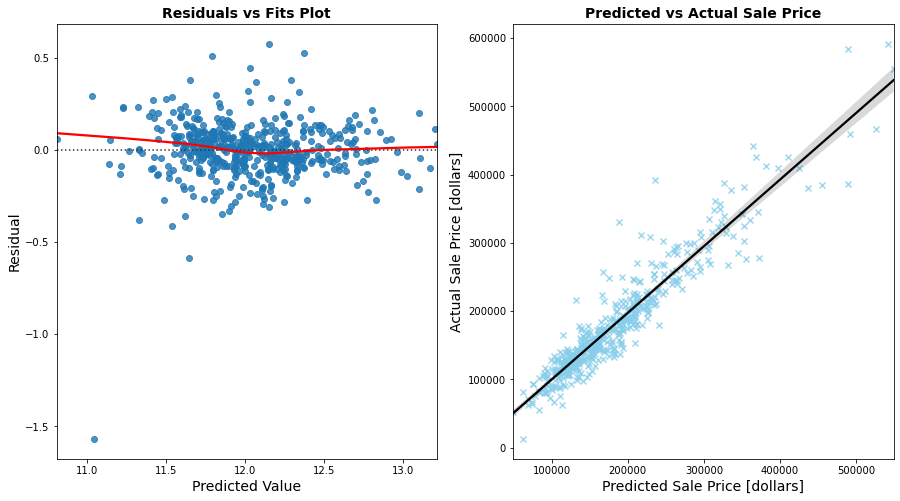

In [15]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'}, ax=ax1)
ax1.set_title('Residuals vs Fits Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Predicted Value', fontsize=14)

sns.regplot(x=np.exp(preds_val), y=y_val, marker='x', color='skyblue', ax=ax2, line_kws={'color':'black'})
ax2.set_xlabel('Predicted Sale Price [dollars]', fontsize=14)
ax2.set_ylabel('Actual Sale Price [dollars]', fontsize=14)
ax2.set_title('Predicted vs Actual Sale Price', fontsize=14, fontweight='bold')
plt.show()

That looks a lot better overall, but there are some serious overpredictions on the lower end. Which I guess makes sense to some degree - if a house costs eg. 40,000 dollars but our model predicts 100,000 dollars, we are going to be off by a lot in logspace. However, in the end we care about the RMSE of the y transformed back to actual dollars. So while that outlier looks bad in logspace, it's not going to look nearly as bad in linear space.

In [16]:
def make_kaggle_df(df, r_obj, islog=False):
    """
    With an input dataframe and sklearn regression object
    construct a dataframe for Kaggle submission
    """
    X_test = df.drop(columns=['Id'])
    ids = df['Id']
    
    preds = r_obj.predict(X_test)
    if islog == True:
        preds = np.exp(preds)
    
    d = {'SalePrice': preds}
    kaggle_m1 = pd.DataFrame(data=d, index=ids)
    return kaggle_m1

In [17]:
#Make a Kaggle submission
df_model_test= pd.read_csv('../model_inputs/test_engineered_m1.csv')
kaggle_m1 = make_kaggle_df(df_model_test, lr, islog=True)
#kaggle_m1.to_csv('../datasets/submission_lin_m1.csv')

## Model 2

In [18]:
#load in the feature engineered training data for model 2
df_model2= pd.read_csv('../model_inputs/train_engineered_m2.csv')
df_model2.head()

,Id,tot_area,gar_adj_area,yr_built,yr_remod,qual,tot_rooms_abv,Full Bath,adj_mas_vnr_area,adj_fireplace,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice
0,109,2204.0,475.000000,1976,2005,6,6,2,289.0,0.0,...,0,0,0,1,0,0,0,0,0,130500
1,544,3035.0,559.000000,1996,1997,7,8,2,132.0,1.0,...,0,0,0,0,1,0,0,0,0,220000
2,153,2114.0,164.452998,1953,2007,5,5,1,0.0,0.0,...,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,457.146484,2006,2007,5,7,2,0.0,0.0,...,0,0,0,0,0,0,0,1,0,174000
4,255,2121.0,323.557931,1900,1993,6,6,2,0.0,0.0,...,0,0,0,0,1,0,0,0,0,138500


In [19]:
X = df_model2.drop(columns=['Id', 'SalePrice'])
y = df_model2['SalePrice']

In [20]:
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [21]:
print_metrics(lr, X_train, X_val, y_train, y_val)

The training r2 score is 0.8754340113536129
The validation r2 score is 0.8717136850496329
The cross validation score is 0.8652569124624929
------------------------------------------------------------
The training RMSE score is 27878.248728875817
The validation RMSE score is 28546.32947145986


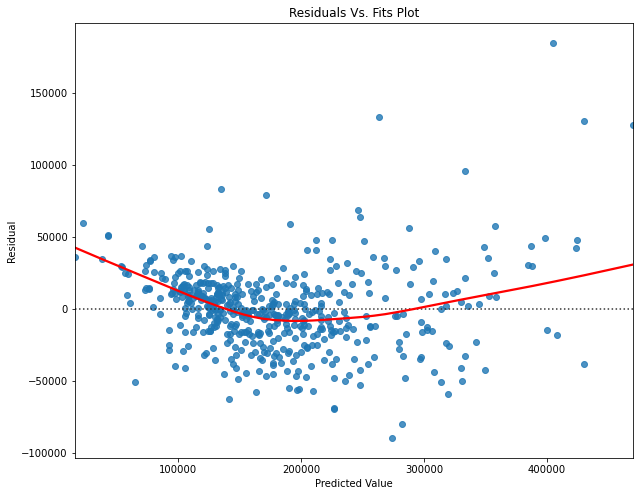

In [22]:
preds_val = lr.predict(X_val)
resids = y_val - preds_val
plt.figure(figsize=(10,8))
sns.residplot(x = preds_val,  y = resids, lowess = True, 
              line_kws = {'color': 'red'})\
    .set(title = 'Residuals Vs. Fits Plot',
        xlabel = 'Predicted Value',
        ylabel = 'Residual');

Yeah, that still looks bad. Let's try a log transform again

In [23]:
lr.fit(X_train, np.log(y_train))

LinearRegression()

In [24]:
print_metrics(lr, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.9013450294642926
The validation r2 score is 0.8583798602876096
The cross validation score is 0.8906485381679877
------------------------------------------------------------
The training RMSE score is 23746.581375341066
The validation RMSE score is 23644.28770928987


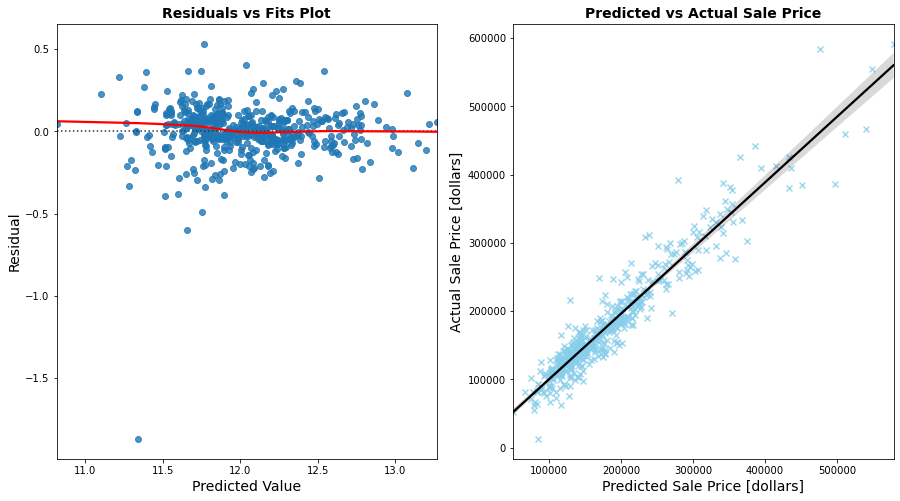

In [25]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'}, ax=ax1)
ax1.set_title('Residuals vs Fits Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Predicted Value', fontsize=14)

sns.regplot(x=np.exp(preds_val), y=y_val, marker='x', color='skyblue', ax=ax2, line_kws={'color':'black'})
ax2.set_xlabel('Predicted Sale Price [dollars]', fontsize=14)
ax2.set_ylabel('Actual Sale Price [dollars]', fontsize=14)
ax2.set_title('Predicted vs Actual Sale Price', fontsize=14, fontweight='bold')
plt.show()

In [26]:
#Make another Kaggle submission with the more complex model
df_model_test= pd.read_csv('../model_inputs/test_engineered_m2.csv')
kaggle_m2 = make_kaggle_df(df_model_test, lr, islog=True)
#kaggle_m2.to_csv('../datasets/submission_lin_m2.csv')

What if we try a ridge regression for this model input? Since ridge includes a regularization parameter, it's a good idea to scale our data

In [27]:
#I found this pipeline method here https://joaquinamatrodrigo.github.io/skforecast/0.4.1/guides/sklearn-pipeline.html
pipe = make_pipeline(StandardScaler(), Ridge())
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridge', Ridge())])

In [28]:
print_metrics(pipe, X_train, X_val, y_train, y_val, islog=True)

The training r2 score is 0.9013447887455204
The validation r2 score is 0.858370366923975
The cross validation score is 0.8906625015151288
------------------------------------------------------------
The training RMSE score is 23747.06727784232
The validation RMSE score is 23640.769507245368


For this model, the ridge regression and normal linear regression perform really similarly

In [29]:
#Make another Kaggle submission with the model 2 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m2.csv')
kaggle_m2 = make_kaggle_df(df_model_test, pipe, islog=True)
#kaggle_m2.to_csv('../datasets/submission_ridge_m2.csv')

## Model 3

In [30]:
#load in the feature engineered training data for model 3
#This is similar to model 2, but using the unadjusted values for garage area, mas vnr area, and fireplaces
df_model3= pd.read_csv('../model_inputs/train_engineered_m3.csv')
df_model3.head()

,Id,tot_area,Garage Area,yr_built,yr_remod,qual,tot_rooms_abv,Full Bath,mas_vnr_area,fireplaces,...,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,SalePrice
0,109,2204.0,475.0,1976,2005,6,6,2,289.0,0,...,0,0,0,1,0,0,0,0,0,130500
1,544,3035.0,559.0,1996,1997,7,8,2,132.0,1,...,0,0,0,0,1,0,0,0,0,220000
2,153,2114.0,246.0,1953,2007,5,5,1,0.0,0,...,0,0,0,0,0,0,0,0,0,109000
3,318,1828.0,400.0,2006,2007,5,7,2,0.0,0,...,0,0,0,0,0,0,0,1,0,174000
4,255,2121.0,484.0,1900,1993,6,6,2,0.0,0,...,0,0,0,0,1,0,0,0,0,138500


Let's go straight to log-transformed regression, because it seems it scores much better overall

In [31]:
X = df_model3.drop(columns=['Id', 'SalePrice'])
y = df_model3['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [32]:
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9007198040259546
The validation r2 score is 0.8538449127640642
The cross validation score is 0.8903744234120443
------------------------------------------------------------
The training RMSE score is 23873.000251982732
The validation RMSE score is 23534.982762563006


It seems that all my effort to calculate 'adjusted' columns in Models 1 and 2 might have been for nothing - the model might actually improve slihtly if I use the unadjusted columns.
For Model 2, we saw that the Ridge Regression scored very similarly to OLS - is that true for this model too?

In [33]:
#I found this pipeline method here https://joaquinamatrodrigo.github.io/skforecast/0.4.1/guides/sklearn-pipeline.html
pipe = make_pipeline(MinMaxScaler(), Ridge())
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge())])

In [34]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.899484827937777
The validation r2 score is 0.8517567431808323
The cross validation score is 0.8892941078953832
------------------------------------------------------------
The training RMSE score is 24091.367124314133
The validation RMSE score is 23663.856732105076


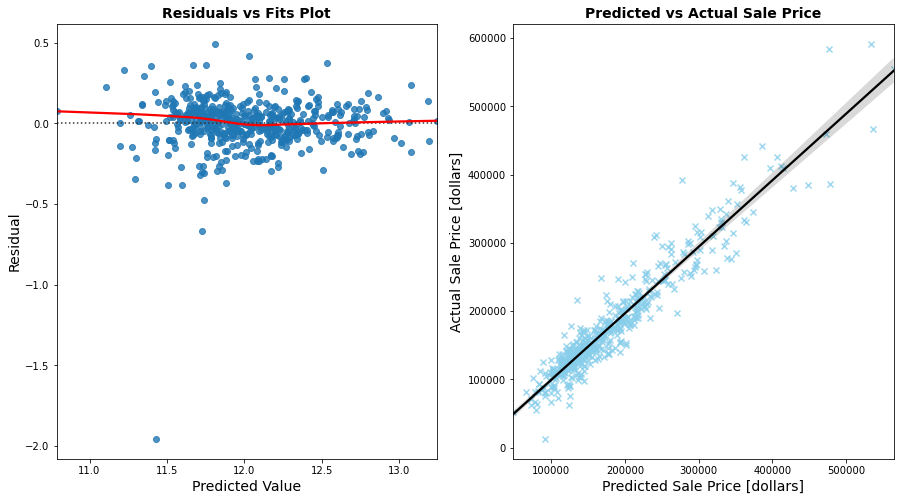

In [35]:
preds_val = lr.predict(X_val)
resids = np.log(y_val) - preds_val
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.residplot(x = preds_val,
              y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'}, ax=ax1)
ax1.set_title('Residuals vs Fits Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Predicted Value', fontsize=14)

sns.regplot(x=np.exp(preds_val), y=y_val, marker='x', color='skyblue', ax=ax2, line_kws={'color':'black'})
ax2.set_xlabel('Predicted Sale Price [dollars]', fontsize=14)
ax2.set_ylabel('Actual Sale Price [dollars]', fontsize=14)
ax2.set_title('Predicted vs Actual Sale Price', fontsize=14, fontweight='bold')
plt.show()

In [36]:
# Make a Kaggle submission with the model 3 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m3.csv')
kaggle_m3 = make_kaggle_df(df_model_test, pipe, islog=True)
#kaggle_m3.to_csv('../datasets/submission_ridge_m3.csv')

## Model 4

This is the most complex model, with a total of 69 features

In [37]:
#load in the feature engineered training data for model 4
#this model 
df_model4= pd.read_csv('../model_inputs/train_engineered_m4.csv')
df_model4.head()

,Id,tot_area,gar_area,lot_frontage,yr_built,yr_remod,qual,tot_rooms_abv,full_bath,mas_vnr_area,...,Central Air_N,Alley_Grvl,Alley_Pave,Paved Drive_N,Paved Drive_P,Yr Sold_2007,Yr Sold_2008,Yr Sold_2009,Yr Sold_2010,SalePrice
0,109,2204.0,475.0,89.778892,1976,2005,6,6,2,289.0,...,0,0,0,0,0,0,0,0,1,130500
1,544,3035.0,559.0,43.000000,1996,1997,7,8,2,132.0,...,0,0,0,0,0,0,0,1,0,220000
2,153,2114.0,246.0,68.000000,1953,2007,5,5,1,0.0,...,0,0,0,0,0,0,0,0,1,109000
3,318,1828.0,400.0,73.000000,2006,2007,5,7,2,0.0,...,0,0,0,0,0,0,0,0,1,174000
4,255,2121.0,484.0,82.000000,1900,1993,6,6,2,0.0,...,0,0,0,1,0,0,0,0,1,138500


In [38]:
X = df_model4.drop(columns=['Id', 'SalePrice'])
y = df_model4['SalePrice']
X_train, X_val, y_train, y_val= train_test_split(X, y, random_state=42)
lr = LinearRegression()
lr.fit(X_train,np.log(y_train))

LinearRegression()

In [39]:
print_metrics(lr, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9208221412570458
The validation r2 score is 0.8837273029862825
The cross validation score is 0.9086692297928594
------------------------------------------------------------
The training RMSE score is 21588.734160950287
The validation RMSE score is 22144.306878985684


Let's try a Ridge model again, and apply a MinMaxScaler

In [40]:
pipe = make_pipeline(MinMaxScaler(), Ridge(alpha=1))
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('ridge', Ridge(alpha=1))])

In [41]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9195027655061023
The validation r2 score is 0.8820809200153774
The cross validation score is 0.9076592213250896
------------------------------------------------------------
The training RMSE score is 21767.69996952264
The validation RMSE score is 22364.6007262696


That seems to be quite similar to normal least squares. Maybe a standardscaler would work better?

In [42]:
#scale data and apply a Ridge model
pipe = make_pipeline(StandardScaler(), Ridge(alpha=1))
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=1))])

In [43]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9208218307875481
The validation r2 score is 0.8837235365578574
The cross validation score is 0.9086881716600601
------------------------------------------------------------
The training RMSE score is 21588.676801620506
The validation RMSE score is 22140.84522828395


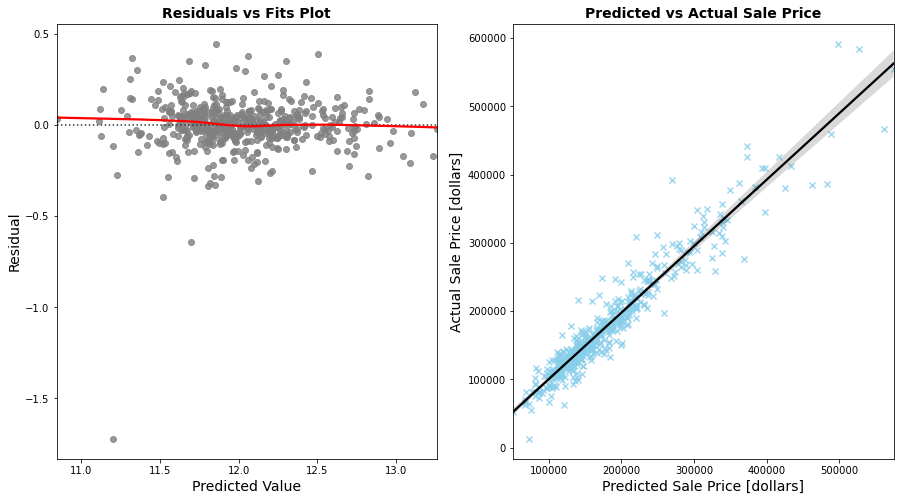

In [59]:
preds_val = pipe.predict(X_val)
resids = np.log(y_val) - preds_val
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
sns.residplot(x = preds_val, y = resids,
              lowess = True, #help visualize relationship
              line_kws = {'color': 'red'}, ax=ax1, color='grey')
ax1.set_title('Residuals vs Fits Plot', fontsize=14, fontweight='bold')
ax1.set_ylabel('Residual', fontsize=14)
ax1.set_xlabel('Predicted Value', fontsize=14)

sns.regplot(x=np.exp(preds_val), y=y_val, marker='x', color='skyblue', ax=ax2, line_kws={'color':'black'})
ax2.set_xlabel('Predicted Sale Price [dollars]', fontsize=14)
ax2.set_ylabel('Actual Sale Price [dollars]', fontsize=14)
ax2.set_title('Predicted vs Actual Sale Price', fontsize=14, fontweight='bold')
plt.savefig('../figures/res_predicted_plot.png', dpi=300)
plt.show()

What about that outlier? It seems to show up in every one of my residual plots, and corresponds with Id 1628 that I identified earlier in the feature engineering notebook. My model predicts a price of around 66000 dollars, but the actual sale price was 12000 dollars, which in logspace is a difference of ln(66/12), or around 1.7. It seems that this outlier was coincidentally in the validation set, so the model didn't actually train on it.

In [45]:
#Make another Kaggle submission with the model 4 ridge
df_model_test= pd.read_csv('../model_inputs/test_engineered_m4.csv')
kaggle_m4 = make_kaggle_df(df_model_test, pipe, islog=True)
kaggle_m4.to_csv('../datasets/submission_ridge_m4.csv')

Now let's try the Ridge model again, but use 'RidgeCV' to bruteforce which penalty term (alpha) leads to the best results

In [46]:
alphas = np.logspace(-1, 5, 400)

pipe = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas))
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-01, 1.03523178e-01, 1.07170483e-01, 1.10946289e-01,
       1.14855124e-01, 1.18901674e-01, 1.23090791e-01, 1.27427499e-01,
       1.31916996e-01, 1.36564666e-01, 1.41376081e-01, 1.46357012e-01,
       1.51513429e-01, 1.56851516e-01, 1.62377674e-01, 1.68098528e-01,
       1.74020937e-01, 1.80152004...
       4.50957214e+04, 4.66845237e+04, 4.83293024e+04, 5.00320295e+04,
       5.17947468e+04, 5.36195677e+04, 5.55086803e+04, 5.74643497e+04,
       5.94889208e+04, 6.15848211e+04, 6.37545637e+04, 6.60007502e+04,
       6.83260739e+04, 7.07333228e+04, 7.32253834e+04, 7.58052437e+04,
       7.84759970e+04, 8.12408458e+04, 8.41031051e+04, 8.70662068e+04,
       9.01337039e+04, 9.33092744e+04, 9.65967258e+04, 1.00000000e+05])))])

In [47]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9206781223667948
The validation r2 score is 0.88350490359553
The cross validation score is 0.9087928102651368
------------------------------------------------------------
The training RMSE score is 21614.164566425603
The validation RMSE score is 22094.990861326816


In [48]:
#what's the best alpha parameter? (I found this way of accessing alpha_ from a pipeline object in the sklearn documentation)
#https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.make_pipeline.html/
pipe.named_steps.ridgecv.alpha_

23.76511113811073

In [49]:
df_model_test= pd.read_csv('../model_inputs/test_engineered_m4.csv')
kaggle_m4 = make_kaggle_df(df_model_test, pipe, islog=True)
kaggle_m4.to_csv('../datasets/submission_ridgecv_m4.csv')

Finally, let's repeat this procedure but for the Lasso model

In [50]:
#alphas for LASSO model are inverted wrt Ridge - higher is 'more shrinkage' of the regularization term
alphas = np.logspace(-6, -1, 400)

pipe = make_pipeline(StandardScaler(), LassoCV(alphas=alphas))
pipe.fit(X_train, np.log(y_train))

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lassocv',
                 LassoCV(alphas=array([1.00000000e-06, 1.02927477e-06, 1.05940656e-06, 1.09042044e-06,
       1.12234225e-06, 1.15519857e-06, 1.18901674e-06, 1.22382494e-06,
       1.25965213e-06, 1.29652816e-06, 1.33448373e-06, 1.37355044e-06,
       1.41376081e-06, 1.45514834e-06, 1.49774748e-06, 1.54159369e-06,
       1.58672350e-06, 1.63317447...
       5.14967058e-02, 5.30042602e-02, 5.45559478e-02, 5.61530608e-02,
       5.77969288e-02, 5.94889208e-02, 6.12304454e-02, 6.30229527e-02,
       6.48679353e-02, 6.67669294e-02, 6.87215161e-02, 7.07333228e-02,
       7.28040247e-02, 7.49353460e-02, 7.71290612e-02, 7.93869969e-02,
       8.17110332e-02, 8.41031051e-02, 8.65652043e-02, 8.90993810e-02,
       9.17077451e-02, 9.43924684e-02, 9.71557865e-02, 1.00000000e-01])))])

In [51]:
pipe.named_steps.lassocv.alpha_

0.0010779074004992725

In [52]:
print_metrics(pipe, X_train, X_val, y_train, y_val,islog=True)

The training r2 score is 0.9202629189865184
The validation r2 score is 0.8836888255865973
The cross validation score is 0.9088509681207674
------------------------------------------------------------
The training RMSE score is 21707.19010924939
The validation RMSE score is 22158.318623031693


Judging by the RMSE, it seems that the lasso model is overall very similar, but slightly worse, than the ridge model.

<b> Overall, it looks like a Ridge regression for model 4 is the best-performing model. </b>